In [1]:
import sys,os
sys.path.insert(0, os.getcwd())

In [86]:
"""
EVALUATION MODULE
=================
This module contains code to evaluate different regression models for resource estimation.
It includes functions to compute performance metrics, visualize results, and compare models.
"""
import numpy as np
import numpy as np
import pandas as pd
from typing import Optional, Tuple, Dict, Any, Callable
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Dict, Tuple



def simple_retry_policy(
        R: int, # retry count, 0 means first attempt
        a0: float, # initial allocation
        ) -> float: # next allocation
    """Simple retry policy: increase allocation by m each time."""

    return (R+1) * a0

def failure_rate(y_true, y_safe):
    """Jobs that would OOM (allocation below actual). Lower is better."""
    return float(np.mean(y_safe < y_true))

def overallocation(y_true, y_safe):
    """Mean relative overallocation. Lower is better (but must balance failure rate)."""
    rel = (y_safe - y_true) / np.clip(y_true, 4, None)
    return float(np.mean(rel))

def binned_metrics(y_true, y_safe, n_bins=10):
    bins = np.linspace(y_true.min(), y_true.max(), n_bins + 1)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    failure_rates = []
    overallocations = []
    bin_counts = []

    for i in range(n_bins):
        bin_mask = (y_true >= bins[i]) & (y_true < bins[i + 1])
        bin_y_true = y_true[bin_mask]
        bin_y_safe = y_safe[bin_mask]
        bin_count = len(bin_y_true)
        bin_counts.append(bin_count)
        if bin_count > 0:
            fr = failure_rate(bin_y_true, bin_y_safe)
            orc = overallocation(bin_y_true, bin_y_safe)
        else:
            fr = np.nan
            orc = np.nan
        failure_rates.append(fr)
        overallocations.append(orc)

    return bin_centers, np.array(failure_rates), np.array(overallocations), np.array(bin_counts)


class JobCost:

    @classmethod
    def simulate_retries(cls, 
                        y_true:        float, # true peak memory
                        true_wall_time: float|None, # the wall time needed for job, if None it will asume that time is proportional to memory
                        retry_allocation_policy:   Callable[[int,float],float], # function to get next allocation given given a0, and attempt number. It return a float or None if no more retries
                        a0:             float, # initial memory allocation
        ) -> Tuple[int, list, float, float]: 
        """
        Simulate retries until success or no more retries.
        Returns (R, a_R, failed_mem_rate_sum) where:
          R = number of retys (0 means success on first attempt),
          alloc_time = tuple with (allocation, wall_time) of each attempt
          a_R = final allocation
          failed_mem_rate_sum = sum of (allocations*wall_time) used in failed attempts
        """
        aR = a0
        R = 0
        failed_alloc_time = []
        failed_mem_rate_sum = 0.0
        while aR < y_true:
            fraction_allocated = aR / y_true
            if true_wall_time is None:
                wall_time = fraction_allocated * 1.0 # assume time proportional to memory
            else:
                wall_time = fraction_allocated * true_wall_time

            failed_mem_rate_sum += aR * wall_time
            failed_alloc_time.append((wall_time, aR))
            
            R += 1
            
            aR = retry_allocation_policy(R, a0)
            if aR is None:
                break
            if aR <= 0:
                raise ValueError("Retry policy returned non-positive allocation.")

        return R, failed_alloc_time, aR, failed_mem_rate_sum


    @classmethod
    def succesful_attempt_waste(cls,
                                aR: float, # final allocation
                                y_true: float, # true peak memory
                                true_wall_time: float|None # the wall time needed for job, if None it will asume that time is proportional to memory
                                ) -> Tuple[list, float]:
        """Compute waste on successful attempt."""
        if aR < y_true:
            raise ValueError("Final allocation must be >= true memory for successful attempt.")
        overalloc = aR - y_true
        if true_wall_time is None:
            wall_time = float(aR) # assume time proportional to memory
        else:
            wall_time = true_wall_time
        return [(wall_time,overalloc)], overalloc * wall_time

    @classmethod
    def job_cost(cls,
                 y_true: float, # true peak memory
                 true_wall_time: float|None, # the wall time needed for job, if None it will asume that time is proportional to memory
                 retry_allocation_policy: Callable[[int,float],float], # function to get next allocation given given a0, and attempt number. It return a float or None if no more retries
                 a0: float, # initial memory allocation. From predictor or heuristic

        ) -> Dict[str, Any]:
        """Compute total cost of job with retries."""
        R, failed_alloc_time, aR, failed_mem_rate_sum = cls.simulate_retries(y_true, true_wall_time, retry_allocation_policy, a0)
        over_alloc_time, overalloc_mem_rate = cls.succesful_attempt_waste(aR, y_true, true_wall_time)
        total_mem_rate = failed_mem_rate_sum + (aR * (true_wall_time if true_wall_time is not None else float(aR)))
        total_waste_rate = overalloc_mem_rate + failed_mem_rate_sum
        waste_alloc_time = failed_alloc_time + over_alloc_time
        total_time = sum(wt for wt, _ in waste_alloc_time)
        return {
            "R": R,
            "a_R": aR,
            "failed_alloc_time": failed_alloc_time,
            "over_alloc_time": over_alloc_time,
            "waste_alloc_time": waste_alloc_time,
            "failed_mem_rate_sum": failed_mem_rate_sum,
            "overalloc_mem_rate": overalloc_mem_rate,
            "total_mem_rate": total_mem_rate,
            "total_time": total_time,
            "total_waste_rate": total_waste_rate
        }
    
    @classmethod
    def batch_job_total_waste_rate(cls,
                                      y_true: np.ndarray, # true peak memory
                                      true_wall_time: np.ndarray|None, # the wall time needed for job, if None it will asume that time is proportional to memory
                                      retry_allocation_policy: Callable[[int,float],float], # function to get next allocation given given a0, and attempt number. It return a float or None if no more retries
                                      a0: np.ndarray, # initial memory allocation. From predictor or heuristic
          ) -> np.ndarray:
          """Compute total waste rate for a batch of jobs."""
          results = [cls.job_cost(yt, twt if true_wall_time is not None else None, retry_allocation_policy, a0i)
                     for yt, twt, a0i in zip(y_true, true_wall_time if true_wall_time is not None else [None]*len(y_true), a0)]
          return np.array([res["total_waste_rate"] for res in results])
    
    @classmethod
    def batch_job_total_time(cls,
                                      y_true: np.ndarray, # true peak memory
                                      true_wall_time: np.ndarray|None, # the wall time needed for job, if None it will asume that time is proportional to memory
                                      retry_allocation_policy: Callable[[int,float],float], # function to get next allocation given given a0, and attempt number. It return a float or None if no more retries
                                      a0: np.ndarray, # initial memory allocation. From predictor or heuristic
          ) -> np.ndarray:
          """Compute total wall time for a batch of jobs."""
          results = [cls.job_cost(yt, twt if true_wall_time is not None else None, retry_allocation_policy, a0i)
                     for yt, twt, a0i in zip(y_true, true_wall_time if true_wall_time is not None else [None]*len(y_true), a0)]
          return np.array([res["total_time"] for res in results])
    


In [147]:
"""
Evaluator for HPC memory predictors.

- Computes importance weights to debias a labeled subset toward a population distribution.
- Evaluates per-job metrics (waste, wall time, failure flag) for one or more predictors.
- Runs weighted Monte Carlo to get means + 95% CIs (per 1000 jobs).
- Optional plotting helpers (matplotlib, one chart per figure, no explicit colors).
- Improved plotting readability for long predictor names, long-tailed metrics, and legends.

Core deps: numpy, pandas (matplotlib is optional unless you call plotting methods).
"""

from __future__ import annotations
from dataclasses import dataclass
from typing import Callable, Dict, Tuple, Optional, List
import numpy as np
import pandas as pd

# ----------------------------
# Config + Result dataclasses
# ----------------------------
@dataclass
class WeightingConfig:
    nbins: int = 60
    log_scale: bool = True
    eps: float = 1e-12
    trim_extreme_bins: bool = True

@dataclass
class MCResult:
    predictor: str
    waste_per_1000_mean: float
    waste_per_1000_lo: float
    waste_per_1000_hi: float
    wall_per_1000_mean: Optional[float]
    wall_per_1000_lo: Optional[float]
    wall_per_1000_hi: Optional[float]
    failure_rate_mean: float
    failure_rate_lo: float
    failure_rate_hi: float

# ----------------------------
# Helper functions (pure)
# ----------------------------
def _make_bins(x: np.ndarray, nbins=60, log=True) -> np.ndarray:
    x = np.asarray(x, float)
    x = x[np.isfinite(x) & (x > 0)]
    if x.size == 0:
        raise ValueError("All values are non-positive or non-finite; cannot make bins.")
    xmin, xmax = float(np.min(x)), float(np.max(x))
    if log:
        return np.logspace(np.log10(xmin) * 0.999, np.log10(xmax) * 1.001, nbins + 1)
    return np.linspace(xmin * 0.999, xmax * 1.001, nbins + 1)

def _hist_density(x: np.ndarray, bins: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    h, e = np.histogram(x, bins=bins, density=True)
    return h.astype(float), e

def _assign_bins(x: np.ndarray, edges: np.ndarray) -> np.ndarray:
    idx = np.digitize(x, edges) - 1
    idx[(x < edges[0]) | (x >= edges[-1])] = -1
    return idx

def _weighted_monte_carlo(values: np.ndarray, weights: np.ndarray,
                          n_jobs: int = 1000, n_iter: int = 5000, seed: int = 0):
    rng = np.random.default_rng(seed)
    idx = np.arange(len(values))
    draws = np.empty(n_iter, dtype=float)
    for i in range(n_iter):
        sidx = rng.choice(idx, size=n_jobs, replace=True, p=weights)
        draws[i] = float(np.mean(values[sidx]))
    mean = float(np.mean(draws))
    lo, hi = [float(v) for v in np.percentile(draws, [2.5, 97.5])]
    return mean, lo, hi, draws

# ----------------------------
# Plot helpers
# ----------------------------
def _wrap_labels(labels, width: int = 18):
    """Word-wrap tick labels to multiple lines."""
    import textwrap
    wrapped = []
    for lab in labels:
        s = str(lab) if lab is not None else ""
        wrapped.append("\n".join(textwrap.wrap(s, width=width, break_long_words=True)))
    return wrapped

def _auto_figsize(n_items: int, orientation: str = "vertical"):
    """
    Returns a (w, h) tuple scaled by item count.
    Vertical: increase width a bit; Horizontal: grow height with items.
    """
    if orientation == "horizontal":
        # more items => taller figure
        h = min(12, 3.5 + 0.32 * max(0, n_items - 3))
        w = 8
    else:
        # more items => wider figure
        w = min(14, 6 + 0.5 * max(0, n_items - 4))
        h = 5
    return (w, h)

def _fmt_thousands():
    from matplotlib.ticker import FuncFormatter
    return FuncFormatter(lambda x, pos: f"{x:,.0f}")

def _legend_space(n_items: int, max_label_len: int) -> Tuple[float, List[float]]:
    """
    Decide how much extra width to allocate and what right margin to reserve when placing the legend outside.
    Returns (extra_width, rect) where rect is [left, bottom, right, top] for tight_layout.
    """
    # Heuristic: more items and longer labels => need more width.
    extra = min(12.0, 2.2 + 0.18 * n_items + 0.06 * max(0, max_label_len - 12))
    # Reserve ~20–25% of the canvas for the legend column.
    rect = [0, 0, 0.78, 1]  # right=0.78 leaves 22% for legend
    return extra, rect

# ----------------------------
# Default metric proxies (fixed signatures)
# (swap these for production if you have better ones)
# ----------------------------
def default_total_waste(true_mem: np.ndarray,
                        base_time: Optional[np.ndarray],
                        pred_mem: np.ndarray) -> np.ndarray:
    """Over-allocation only (no penalty for under)."""
    return np.maximum(pred_mem - true_mem, 0.0)

def default_total_wall_time(true_mem: np.ndarray,
                            base_time: Optional[np.ndarray],
                            pred_mem: np.ndarray) -> np.ndarray:
    """
    If under-allocated (pred < true), assume one failure + rerun (100% time penalty).
    Requires base_time to be provided by the evaluator.
    """
    if base_time is None:
        raise ValueError("base_time is required for wall time computation.")
    under = pred_mem < true_mem
    return base_time * (1.0 + under.astype(float))

# ----------------------------
# Main class
# ----------------------------
class HPCMemoryEvaluator:
    """
    Usage:
        ev = HPCMemoryEvaluator(sample_true, pop_true, predictors, base_wall_time=..., ...)
        ev.compute_importance_weights()
        summary_df, draws = ev.evaluate(n_jobs=1000, n_iter=4000, seed=42)
        ev.save_summary_csv("summary.csv")
    """

    def __init__(
        self,
        sample_peak_true: np.ndarray,
        pop_peak_true: np.ndarray,
        predictors: Dict[str, np.ndarray],
        total_waste_fn: Callable[
            [np.ndarray, Optional[np.ndarray], np.ndarray], np.ndarray
        ],
        total_wall_time_fn: Optional[
            Callable[[np.ndarray, Optional[np.ndarray], np.ndarray], np.ndarray]
        ],
        base_wall_time: Optional[np.ndarray] = None,
        weighting_cfg: WeightingConfig = WeightingConfig(),
    ):
        # Validate/standardize inputs
        self.sample_true = np.asarray(sample_peak_true, float)
        self.pop_true = np.asarray(pop_peak_true, float)
        self.predictors = {k: np.asarray(v, float) for k, v in predictors.items()}
        if not all(len(v) == len(self.sample_true) for v in self.predictors.values()):
            raise ValueError("All predictor arrays must match the labeled sample length.")
        self.N = len(self.sample_true)

        # Optional wall time
        self.base_wall_time = None if base_wall_time is None else np.asarray(base_wall_time, float)
        if self.base_wall_time is not None and len(self.base_wall_time) != self.N:
            raise ValueError("base_wall_time length must match the labeled sample length.")

        self.weighting_cfg = weighting_cfg
        self.total_waste_fn = total_waste_fn
        self.total_wall_time_fn = total_wall_time_fn if self.base_wall_time is not None else None

        # Filled later
        self.weights: Optional[np.ndarray] = None
        self.weight_info: Optional[Dict] = None
        self.per_job_metrics: Optional[Dict[str, Dict[str, np.ndarray]]] = None
        self.summary_df: Optional[pd.DataFrame] = None
        self.draws_store: Optional[Dict[str, Dict[str, np.ndarray]]] = None

    # ---- weighting ----
    def compute_importance_weights(self) -> Tuple[np.ndarray, Dict]:
        cfg = self.weighting_cfg
        bins = _make_bins(np.concatenate([self.pop_true, self.sample_true]), nbins=cfg.nbins, log=cfg.log_scale)
        p_true, edges = _hist_density(self.pop_true, bins)
        p_samp, _ = _hist_density(self.sample_true, bins)
        ratio = (p_true + cfg.eps) / (p_samp + cfg.eps)

        if cfg.trim_extreme_bins:
            ratio[p_samp < cfg.eps * 10] = np.nan

        bidx = _assign_bins(self.sample_true, edges)
        w = np.full(self.N, np.nan, dtype=float)
        in_range = bidx >= 0
        w[in_range] = ratio[bidx[in_range]]
        valid_bins = np.where(np.isfinite(ratio))[0]
        if valid_bins.size == 0:
            w[:] = 1.0 / self.N
        else:
            for i in np.where(~np.isfinite(w))[0]:
                b = max(bidx[i], 0)
                nearest = valid_bins[np.argmin(np.abs(valid_bins - b))]
                w[i] = ratio[nearest]
        w = w / np.sum(w)

        self.weights = w
        self.weight_info = {"bins": bins, "p_true": p_true, "p_samp": p_samp, "edges": edges, "ratio": ratio}
        return w, self.weight_info

    # ---- metrics ----
    def _build_per_job_metrics(self) -> Dict[str, Dict[str, np.ndarray]]:
        if self.weights is None:
            raise RuntimeError("Call compute_importance_weights() first.")
        metrics: Dict[str, Dict[str, np.ndarray]] = {}
        for name, pred in self.predictors.items():
            waste = self.total_waste_fn(self.sample_true, self.base_wall_time, pred)
            fail = (self.sample_true > pred).astype(float)
            entry = {"waste": waste, "fail": fail}
            if self.total_wall_time_fn is not None:
                entry["wall"] = self.total_wall_time_fn(self.sample_true, self.base_wall_time, pred)  # type: ignore[arg-type]
            metrics[name] = entry
        self.per_job_metrics = metrics
        return metrics

    # ---- evaluation (weighted MC) ----
    def evaluate(self, n_jobs: int = 1000, n_iter: int = 4000, seed: int = 100
                 ) -> Tuple[pd.DataFrame, Dict[str, Dict[str, np.ndarray]]]:
        if self.weights is None:
            self.compute_importance_weights()
        if self.per_job_metrics is None:
            self._build_per_job_metrics()

        summary_rows: List[Dict] = []
        draws_store: Dict[str, Dict[str, np.ndarray]] = {}
        scale = 1000.0

        for i, (name, m) in enumerate(self.per_job_metrics.items()):
            w_mean, w_lo, w_hi, w_draws = _weighted_monte_carlo(m["waste"], self.weights, n_jobs, n_iter, seed=seed + 17 * i + 1)
            f_mean, f_lo, f_hi, f_draws = _weighted_monte_carlo(m["fail"], self.weights, n_jobs, n_iter, seed=seed + 17 * i + 3)

            wall_mean = wall_lo = wall_hi = None
            wall_draws = None
            if "wall" in m:
                t_mean, t_lo, t_hi, t_draws = _weighted_monte_carlo(m["wall"], self.weights, n_jobs, n_iter, seed=seed + 17 * i + 2)
                wall_mean, wall_lo, wall_hi = t_mean * scale, t_lo * scale, t_hi * scale
                wall_draws = t_draws * scale

            res = MCResult(
                predictor=name,
                waste_per_1000_mean=w_mean * scale, waste_per_1000_lo=w_lo * scale, waste_per_1000_hi=w_hi * scale,
                wall_per_1000_mean=wall_mean, wall_per_1000_lo=wall_lo, wall_per_1000_hi=wall_hi,
                failure_rate_mean=f_mean, failure_rate_lo=f_lo, failure_rate_hi=f_hi,
            )
            summary_rows.append(res.__dict__)

            draws_store[name] = {
                "waste": w_draws * scale,
                "fail": f_draws,
                **({"wall": wall_draws} if wall_draws is not None else {}),
            }

        self.summary_df = pd.DataFrame(summary_rows)
        self.draws_store = draws_store
        return self.summary_df, self.draws_store

    # ---- persistence ----
    def save_summary_csv(self, path: str) -> None:
        if self.summary_df is None:
            raise RuntimeError("Nothing to save. Run evaluate() first.")
        self.summary_df.to_csv(path, index=False)

    # ---- optional visuals (matplotlib only) ----
    def plot_errorbars(self, metric: str = "waste") -> None:
        """
        metric ∈ {"waste", "wall"}; shows mean +/- 95% CI per predictor (per 1000 for waste/wall).
        Uses horizontal error bars when labels are long or there are many predictors.
        """
        if self.summary_df is None:
            raise RuntimeError("Run evaluate() first.")
        import numpy as np
        import matplotlib.pyplot as plt

        if metric == "waste":
            y = "waste_per_1000_mean"; lo = "waste_per_1000_lo"; hi = "waste_per_1000_hi"
            axis_label = "Total waste per 1000 jobs"
            title = "Predictor comparison — Total waste (95% CI)"
        elif metric == "wall":
            y = "wall_per_1000_mean"; lo = "wall_per_1000_lo"; hi = "wall_per_1000_hi"
            axis_label = "Total wall time per 1000 jobs (minutes)"
            title = "Predictor comparison — Wall time (95% CI)"
        else:
            raise ValueError("metric must be 'waste' or 'wall'.")

        df = self.summary_df.dropna(subset=[y]).copy()
        labels = df["predictor"].astype(str).tolist()

        # Heuristic: if any label is long or there are many predictors, go horizontal
        long_label = any(len(s) > 18 for s in labels)
        many = len(labels) > 6
        horizontal = long_label or many

        # Prepare data
        means = df[y].values
        los = means - df[lo].values
        his = df[hi].values - means

        fig_w, fig_h = _auto_figsize(len(labels), "horizontal" if horizontal else "vertical")
        plt.figure(figsize=(fig_w, fig_h))
        ax = plt.gca()

        if horizontal:
            pos = np.arange(len(labels))
            ax.errorbar(means, pos, xerr=[los, his], fmt="o", capsize=6)
            ax.set_xlabel(axis_label)
            ax.set_yticks(pos)
            ax.set_yticklabels(_wrap_labels(labels, width=22))
            ax.xaxis.set_major_formatter(_fmt_thousands())
        else:
            pos = np.arange(len(labels))
            ax.errorbar(pos, means, yerr=[los, his], fmt="o", capsize=6)
            ax.set_xticks(pos)
            ax.set_xticklabels(_wrap_labels(labels, width=18), rotation=0)
            ax.set_ylabel(axis_label)
            ax.yaxis.set_major_formatter(_fmt_thousands())

        ax.set_title(title)
        ax.grid(True, linestyle="--", alpha=0.4)
        plt.tight_layout()
        plt.show()

    def plot_weighted_ccdf(
        self,
        metric: str = "waste",
        clip_min_quantile: float = 0.0,
        log_y: bool = True,
        legend: str = "outside",
    ) -> None:
        """
        Plot the (weighted) complementary CDF (1 - CDF), which makes long tails
        much easier to compare. By default, uses log-scale on Y to highlight the tail.

        - clip_min_quantile: left-trims the very small values to focus on the right tail.
        - legend: "outside" | "inside" | "none"
        """
        if self.per_job_metrics is None or self.weights is None:
            raise RuntimeError("Run compute_importance_weights() and evaluate() first.")
        import numpy as np
        import matplotlib.pyplot as plt

        names = [n for n, m in self.per_job_metrics.items() if metric in m]
        if not names:
            raise ValueError(f"No predictors contain metric '{metric}'.")

        # Layout & legend
        base_w, base_h = _auto_figsize(len(names), "vertical")
        fig_w, fig_h = base_w, base_h
        rect = None
        if legend == "outside":
            extra_w, rect = _legend_space(len(names), max(len(s) for s in names))
            fig_w += extra_w

        plt.figure(figsize=(fig_w, fig_h))
        ax = plt.gca()

        # Build a shared x-grid from pooled values (weighted quantiles)
        pooled = []
        pooled_w = []
        for name in names:
            v = np.asarray(self.per_job_metrics[name][metric], float)
            m = np.isfinite(v)
            pooled.append(v[m])
            pooled_w.append(self.weights[m])
        pooled = np.concatenate(pooled)
        pooled_w = np.concatenate(pooled_w)

        # Optionally left-trim to focus on the right tail
        order = np.argsort(pooled)
        v_sorted = pooled[order]
        w_sorted = pooled_w[order]
        w_cum = np.cumsum(w_sorted)
        w_cum /= w_cum[-1]
        xmin = np.interp(clip_min_quantile, w_cum, v_sorted)
        xgrid = np.linspace(xmin, v_sorted[-1], 300)

        for name in names:
            v = np.asarray(self.per_job_metrics[name][metric], float)
            m = np.isfinite(v)
            v = v[m]
            w = self.weights[m]
            # Weighted ECDF
            o = np.argsort(v)
            vs = v[o]
            ws = w[o]
            wc = np.cumsum(ws)
            wc /= wc[-1]
            # For each xgrid, compute CCDF = 1 - CDF(x)
            cdf = np.interp(xgrid, vs, wc, left=0.0, right=1.0)
            ccdf = 1.0 - cdf
            ax.plot(xgrid, ccdf, label=name)

        ax.set_xlabel(f"Per-job {metric}")
        ax.set_ylabel("1 - CDF")
        ax.set_title("Complementary CDF (weighted) — tail comparison")
        if log_y:
            ax.set_yscale("log")
        ax.grid(True, linestyle="--", alpha=0.3)

        if legend == "outside":
            ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0.)
            if rect is not None:
                plt.tight_layout(rect=rect)
            else:
                plt.tight_layout()
        elif legend == "inside":
            ax.legend()
            plt.tight_layout()
        else:
            plt.tight_layout()
        plt.show()

    def plot_mc_distribution(
        self,
        metric: str = "waste",
        bins: int = 40,
        clip_quantile: Tuple[float, float] = (0.0, 0.995),
        legend: str = "outside",  # "outside" | "inside" | "none"
    ) -> None:
        """
        Overlay MC sampling distributions across predictors (per 1000 for waste/wall).
        - Uses quantile clipping to avoid very long tails squeezing the view.
        - Legend placed outside by default, but the figure expands to keep the plot wide.

        metric ∈ {"waste", "wall", "fail"}.
        """
        if self.draws_store is None:
            raise RuntimeError("Run evaluate() first.")
        import numpy as np
        import matplotlib.pyplot as plt

        names = [n for n, d in self.draws_store.items() if metric in d]
        if not names:
            raise ValueError(f"No predictors contain metric '{metric}'.")

        # Build pooled draws to get global clipping range
        pooled = []
        for name in names:
            v = np.asarray(self.draws_store[name][metric], float)
            pooled.append(v[np.isfinite(v)])
        pooled = np.concatenate(pooled)
        if pooled.size == 0:
            raise ValueError(f"No finite draws for metric '{metric}'.")

        lo_q, hi_q = clip_quantile
        lo = np.quantile(pooled, lo_q)
        hi = np.quantile(pooled, hi_q)
        clipped_pct = 100.0 * (1.0 - (hi_q - lo_q))

        # Layout & legend
        base_w, base_h = _auto_figsize(len(names), "vertical")
        fig_w, fig_h = base_w, base_h
        rect = None
        if legend == "outside":
            extra_w, rect = _legend_space(len(names), max(len(s) for s in names))
            fig_w += extra_w

        plt.figure(figsize=(fig_w, fig_h))
        ax = plt.gca()

        edges = np.linspace(lo, hi, bins + 1)
        for name in names:
            v = np.asarray(self.draws_store[name][metric], float)
            v = v[np.isfinite(v)]
            counts, edges_i = np.histogram(np.clip(v, lo, hi), bins=edges, density=True)
            centers = 0.5 * (edges_i[1:] + edges_i[:-1])
            ax.plot(centers, counts, label=name)

        pretty = {"waste": "Total waste per 1000 jobs", "wall": "Total wall time per 1000 jobs (min)", "fail": "Failure rate"}
        ax.set_xlabel(pretty.get(metric, metric))
        ax.set_ylabel("Density")
        ax.set_title(
            f"Monte Carlo distribution — {pretty.get(metric, metric)}\n"
            f"View clipped to [{int(lo_q*100)}–{int(hi_q*100)}]th pct ({clipped_pct:.1f}% trimmed)"
        )
        ax.grid(True, linestyle="--", alpha=0.3)

        if legend == "outside":
            ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0.)
            if rect is not None:
                plt.tight_layout(rect=rect)
            else:
                plt.tight_layout()
        elif legend == "inside":
            ax.legend()
            plt.tight_layout()
        else:
            plt.tight_layout()
        plt.show()

    def plot_tradeoff(self) -> None:
        """Pareto-ish scatter: failure rate vs waste (mean estimates) with wrapped labels and light jitter to reduce overlaps."""
        if self.summary_df is None:
            raise RuntimeError("Run evaluate() first.")
        import numpy as np
        import matplotlib.pyplot as plt

        df = self.summary_df.copy()
        x = df["failure_rate_mean"].values
        y = df["waste_per_1000_mean"].values
        labels = df["predictor"].astype(str).tolist()

        fig_w, fig_h = _auto_figsize(len(labels), "vertical")
        plt.figure(figsize=(fig_w, fig_h))
        ax = plt.gca()
        ax.scatter(x, y)

        # Light, deterministic jitter to reduce text overlap (no randomness across runs)
        def _jitter(val, idx, scale):
            return val + scale * (((hash(labels[idx]) % 997) / 997.0) - 0.5)

        for i, lab in enumerate(labels):
            ax.annotate(
                _wrap_labels([lab], width=22)[0],
                (x[i], y[i]),
                xytext=(_jitter(x[i], i, 0.01), _jitter(y[i], i, 0.01)),
                textcoords="data",
                fontsize=9,
                ha="left",
                va="bottom"
            )

        ax.set_xlabel("Failure rate (mean)")
        ax.set_ylabel("Total waste per 1000 jobs (mean)")
        ax.yaxis.set_major_formatter(_fmt_thousands())
        ax.grid(True, linestyle="--", alpha=0.4)
        ax.set_title("Trade-off: Failure vs Waste (weighted MC means)")
        plt.tight_layout()
        plt.show()


__all__ = [
    "HPCMemoryEvaluator",
    "WeightingConfig",
    "MCResult",
    "default_total_waste",
    "default_total_wall_time",
]


In [2]:
# silence all warnings
import warnings
warnings.filterwarnings("ignore")

# Overview
When building models to predict resource estimation of HPC jobs its crucial to have evaluation methods that reflect the real world usage of such prediction systems. This can help us to fine-tune parameter, select best models, and avoid false sense of improvement.

In this notebook we explore different evaluation metrics and how they can be used to evaluate the performance of our models.



# 1. Context Before Content


* Start with the *problem, question, or assumption* everyone shares.
    - Problem: Selecting the best model for resource estimation is challenging as many metrics can be used to capture different aspects of model performance.
    - Question: How to evaluate models in a way that reflects real-world usage?
    - Assumption: Common performance metrics like MAE, RMSE, and R², as well as safety/efficiency bulk metric, are good approximations to select best model.


## Plots showing base metrics (MAE, MSE, R2) and safety/efficiency bulk metric for different models
| Include Gaussian Process method

In [3]:
## From kmer frequency
import argparse
import sys
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_predict

try:
    import xgboost as xgb
    HAS_XGB = True
except Exception:
    HAS_XGB = False

sns.set(style="whitegrid")


def load_stats(stats_path: Path) -> pd.DataFrame:
    # try load with first column as index (common when saving DataFrame.to_csv())
    df = pd.read_csv(stats_path, index_col=0)
    # ensure numeric columns only (drop metrics that are non-numeric)
    df = df.apply(pd.to_numeric, errors="coerce")
    return df


def load_metadata(meta_path: Path) -> pd.DataFrame:
    df = pd.read_csv(meta_path)
    # try common names
    if "srr_id" in df.columns and "peak_mem_in_gbs" in df.columns:
        df2 = df.set_index("srr_id")[["peak_mem_in_gbs"]]
        return df2

    # fallback: try to find the best column names
    candidates = [c for c in df.columns if "srr" in c.lower() or "run" in c.lower()]
    mem_cols = [c for c in df.columns if "mem" in c.lower() or "peak" in c.lower()]
    if candidates and mem_cols:
        idx_col = candidates[0]
        mem_col = mem_cols[0]
        return df.set_index(idx_col)[[mem_col]].rename(columns={mem_col: "peak_mem_in_gbs"})

    raise ValueError("Could not find 'srr_id' and 'peak_mem_in_gbs' columns in metadata."
                     " Please provide a metadata CSV with these columns.")


def compute_tradeoff(y_true: np.ndarray, y_pred_base: np.ndarray, adjustment_steps: np.ndarray):
    underpred_percent_list = []
    excess_memory_list = []
    n_samples = len(y_true)

    for adj in adjustment_steps:
        y_pred_adj = y_pred_base + adj
        under_pred_mask = y_pred_adj < y_true
        under_pred_count = np.sum(under_pred_mask)
        under_pred_percent = (under_pred_count / n_samples) * 100

        # for samples where prediction >= true, compute excess memory
        excess_memory = y_pred_adj[~under_pred_mask] - y_true[~under_pred_mask]
        total_excess_memory = np.sum(excess_memory)

        underpred_percent_list.append(under_pred_percent)
        excess_memory_list.append(total_excess_memory)

    return np.array(underpred_percent_list), np.array(excess_memory_list)

p = argparse.ArgumentParser()

p.add_argument("--output", default="tradeoff_models.png", help="Output plot file (PNG)")
p.add_argument("--adjust-min", type=float, default=-100.0, help="Min adjustment (GB)")
p.add_argument("--adjust-max", type=float, default=100.0, help="Max adjustment (GB)")
p.add_argument("--adjust-step", type=float, default=5.0, help="Adjustment step (GB)")
args = p.parse_args([])



In [4]:
import sys,os
sys.path.append(str(Path(os.getcwd()).resolve().parent))

from training.gaussian_process import *

In [151]:
stats_file = "../../Kmer-Memory-Predict/updated_mgnify_assemblies_stats_v3.15.3_metaspades_kmer_stats.csv"
y_file = "../../Kmer-Memory-Predict/input/updated_mgnify_assemblies_stats_v3.15.3_metaspades_subset.csv"

df = load_your_data(stats_file, y_file)
df = df[df["peak_mem_in_gbs"] <= df["peak_mem_in_gbs"].quantile(0.95)]
df = df[df["file_size"] <= df["file_size"].quantile(0.95)]

stats = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

features_all = stats.columns.tolist()

In [154]:

# build model list
models = [
    ("Random Forest (All)", features_all, RandomForestRegressor(random_state=42)),
    ("File size (Linear)", ["file_size"], LinearRegression()),
]


cv = KFold(n_splits=5, shuffle=True, random_state=42)

quant_results = {}
quantiles = [0.5,0.75,0.8,0.85, 0.9, 0.95, 0.99, 0.995, 0.9999, 0.99999]

# iterate through folds
for train_idx, test_idx in cv.split(stats, y):
    x_train,y_train = stats.iloc[train_idx], y[train_idx]
    x_test,y_test = stats.iloc[test_idx],y[test_idx]
    for title, feat_list, _base_model in models:
    # title, feat_list, model = models[0]
        _base_model.fit(x_train[feat_list],y_train)
        preds = _base_model.predict(x_test[feat_list])
        quant_results.setdefault((title,"default"), np.empty_like(y))[test_idx]  = preds
        
        # model that puts more weight in smaller jobs
        w = 1 / np.clip(y_train, 1, None)
        w = w / w.mean()  # normalize
        _base_model.fit(x_train[feat_list],y_train, sample_weight=w)
        preds  = _base_model.predict(x_test[feat_list])
        quant_results.setdefault((title,"small_biased"), np.empty_like(y))[test_idx]  = preds

    ## BAYES
    model = train_and_save(df.iloc[train_idx], out_path=None, log_target=False)

    # 3) Evaluate on validation split
    X_val = df.iloc[test_idx].drop(columns=[TARGET_COL])
    y_val = df.iloc[test_idx][TARGET_COL].to_numpy(float)

    for _q in quantiles:
        _y_q = model.predict_quantile(X_val, q=_q)
        quant_results.setdefault(("GP",_q), np.empty_like(y))[test_idx]  = _y_q
        

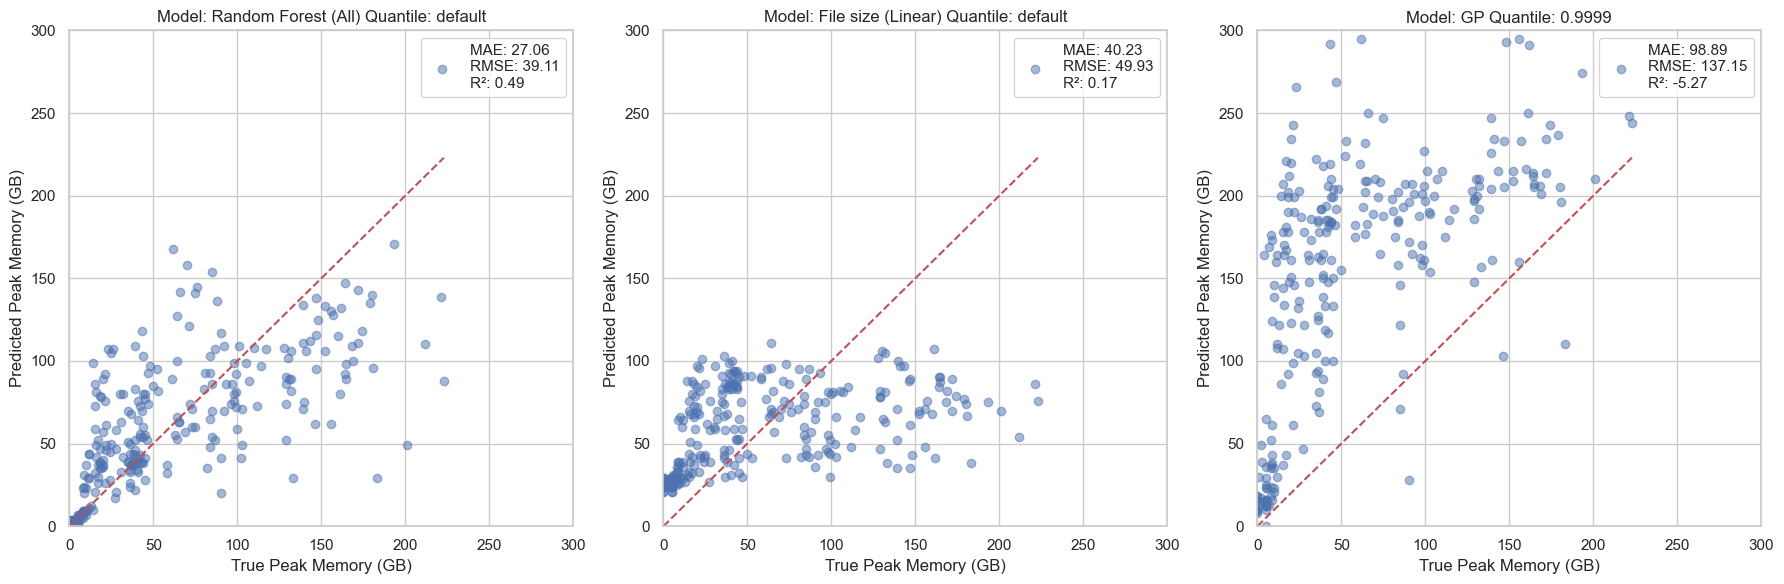

In [15]:
# 3 subplots with scatterplots of predictions vs true. where true = list(y) and pred = quant_results[keys]. The keys I want are [("Random Forest (All)","default"),("File size (Linear)","default"),("GP",0.9999)] 
# - draw diagonal, 
# - also calculate MAE, RMSE, and R² (show in legend)
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
keys = [("Random Forest (All)","default"),("File size (Linear)","default"),("GP",0.9999)]
for ax, key in zip(axes, keys):
    preds = quant_results[key]
    ax.scatter(y, preds, alpha=0.5)
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
    ax.set_title(f"Model: {key[0]} Quantile: {key[1]}")
    ax.set_xlabel("True Peak Memory (GB)")
    ax.set_ylabel("Predicted Peak Memory (GB)")
    mae = mean_absolute_error(y, preds)
    rmse = root_mean_squared_error(y, preds)
    r2 = r2_score(y, preds)
    ax.legend([f"MAE: {mae:.2f}\nRMSE: {rmse:.2f}\nR²: {r2:.2f}"])
    # set limits
    ax.set_xlim(0, 300)
    ax.set_ylim(0, 300)
plt.tight_layout()

In [45]:
# from ..evaluation.memeory_prediction import *


li = []

adjustment_steps = np.arange(args.adjust_min, args.adjust_max + 0.0001, args.adjust_step)



keys = [("Random Forest (All)","default"),("File size (Linear)","default")]
for (key,val) in keys:
    _y_pred = quant_results[(key,val)]

    for adj in adjustment_steps:
        _y_pred_adj = _y_pred + adj
        
        # stats from evaluation module
        failure_rate_val, overallocation_val = failure_rate(y, _y_pred_adj), overallocation(y, _y_pred_adj)
        
        # total exess
        under_pred_mask = _y_pred_adj < y
        under_pred_count = np.sum(under_pred_mask)
        under_pred_percent = (under_pred_count / len(y)) * 100
        
        excess_memory = _y_pred_adj[~under_pred_mask] - y[~under_pred_mask]
        total_excess_memory = np.sum(excess_memory)

        li.append((f"{key}_{round(adj,3)}", key, str(round(adj,3)), failure_rate_val, overallocation_val, under_pred_percent, total_excess_memory))
    
for (method,quant),_y_pred in quant_results.items():
    if method is not "GP":
        continue
    
    # stats from evaluation module
    failure_rate_val, overallocation_val = failure_rate(y, _y_pred), overallocation(y, _y_pred)

    # total exess
    under_pred_mask = _y_pred < y
    under_pred_count = np.sum(under_pred_mask)
    under_pred_percent = (under_pred_count / len(y)) * 100
    
    excess_memory = _y_pred[~under_pred_mask] - y[~under_pred_mask]
    total_excess_memory = np.sum(excess_memory)

    li.append((f"{method}_{quant}", method, str(quant), failure_rate_val, overallocation_val,under_pred_percent, total_excess_memory))


df_with_stats = pd.DataFrame(li, columns=['model_param', 'model', 'param', 'failure_rate', 'overallocation', 'underpred_percent', 'total_excess_memory'])



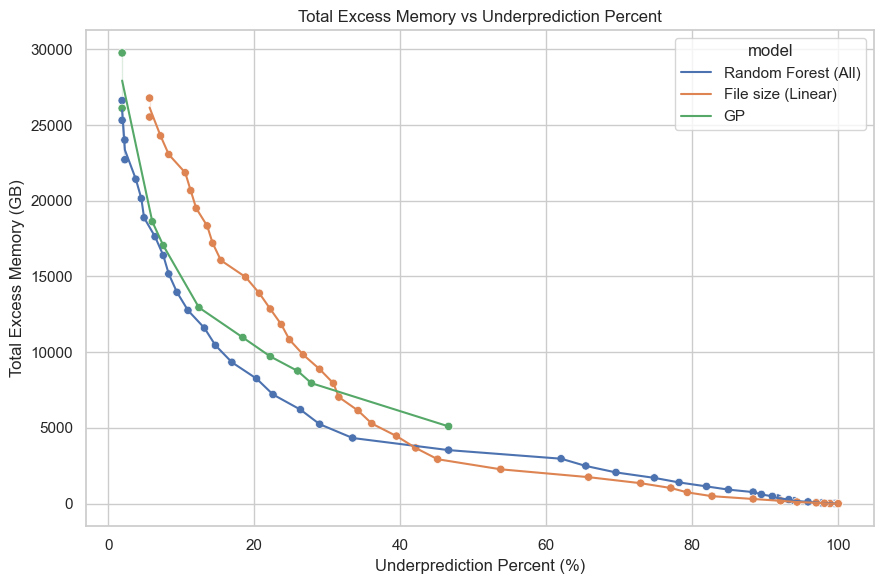

In [55]:
# lineplot of underpred percent vs total excess memory
# show with points for each model
fig, axes = plt.subplots(1, 1, figsize=(9, 6))
# sns.lineplot(data=df_with_stats, y='failure_rate', x='overallocation', hue='model', ax=axes[1])
sns.lineplot(data=df_with_stats, x='underpred_percent', y='total_excess_memory', hue='model', ax=axes)
sns.scatterplot(data=df_with_stats, x='underpred_percent', y='total_excess_memory', hue='model', ax=axes,legend=False)
# axes[1].set_title('Failure Rate vs Overallocation')
# axes[1].set_xlabel('Overallocation')
# axes[1].set_ylabel('Failure Rate')
axes.set_title('Total Excess Memory vs Underprediction Percent')
axes.set_ylabel('Total Excess Memory (GB)')
axes.set_xlabel('Underprediction Percent (%)')

plt.tight_layout()


---


# 2. Create Contrast — Tension and Surprise

Now reveal the unexpected insight **against** that backdrop.

* Use visuals or phrasing to **highlight contrast**: what we thought vs. what’s actually true.



* Don’t dump the data — *build suspense* like a story twist.
* Phrases like “But here’s where it gets interesting…” signal a turning point.

> **Example:** “…but when we analyzed behavioral data, we found that engagement patterns, not pricing, predict churn — and 70% of those customers had never interacted with our onboarding emails.”

---



## Plots showing the different distribution of Reallife memusage frequency vs evaluation dataset

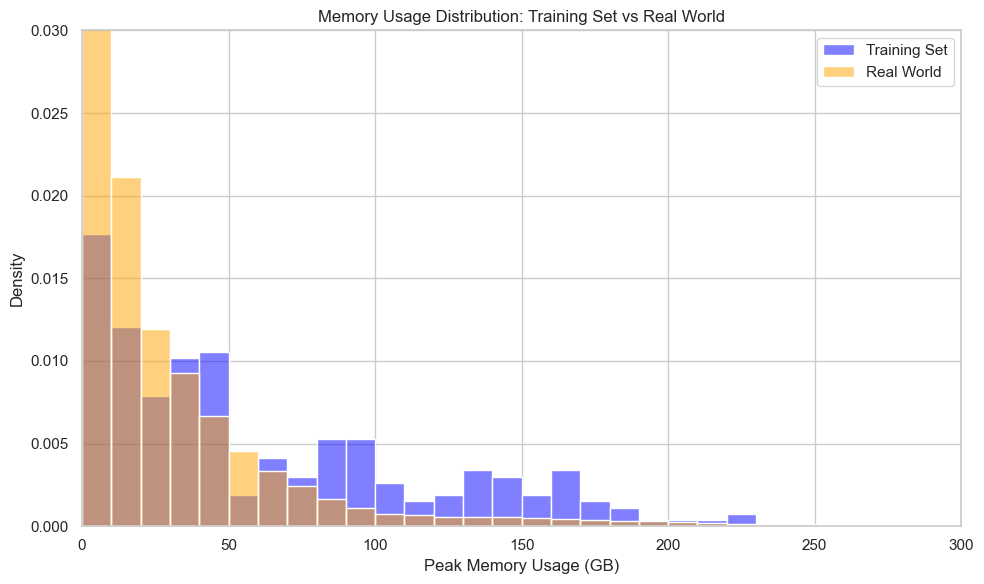

In [6]:
mgnify_dataset = pd.read_csv("../../Kmer-Memory-Predict/input/mgnify_assemblies_stats.csv")

train_set_memory_usage = new_df["peak_mem_in_gbs"]
real_world_memory_usage = mgnify_dataset["peak_mem_in_gbs"]

# plot in one histogram both distributions. bin size 10GB, x limit 0-300GB
# use seaborn for better aesthetics
plt.figure(figsize=(10,6))
sns.histplot(train_set_memory_usage, bins=np.arange(0, 310, 10), color='blue', label='Training Set', kde=False, stat='density', alpha=0.5)
sns.histplot(real_world_memory_usage, bins=np.arange(0, 310, 10), color='orange', label='Real World', kde=False, stat='density', alpha=0.5)
plt.xlim(0, 300)
plt.ylim(0, 0.03)
plt.xlabel('Peak Memory Usage (GB)')
plt.ylabel('Density')
plt.title('Memory Usage Distribution: Training Set vs Real World')
plt.legend()
plt.tight_layout()
plt.show()

## Plots showing bins of mem vs underprediction failure rate

In [92]:
# Make plot of 
n_bins=5
mem_bined_stats = []
for (method,param),_y_pred in quant_results.items():
    if "Random" in str(method):
        adjustment_steps = np.arange(0, 150, 40)
        for step in adjustment_steps:
            _y_pred_adj = _y_pred + step
            bin_centers, failure_rates, overallocations, bin_counts = binned_metrics(y.to_numpy(), _y_pred_adj, n_bins=n_bins)
            for bc,fr,orc,bcnt in zip(bin_centers, failure_rates, overallocations, bin_counts):
                mem_bined_stats.append((f"{method}_{round(step,3)}",f"{method}",f"{round(step,3)}", bc, fr, orc, bcnt))
    # elif "corre" in str(title) or "0.995" not in str(title) or "0.9999" not in str(title):
        # continue
    elif str(param) in ["0.9999"]: 
        bin_centers, failure_rates, overallocations, bin_counts = binned_metrics(y.to_numpy(), _y_pred, n_bins=n_bins)
        for bc,fr,orc,bcnt in zip(bin_centers, failure_rates, overallocations, bin_counts):
            mem_bined_stats.append((f"{method}_{param}",f"{method}", f"{param}", bc, fr, orc, bcnt))
            
mem_bined_stats_df = pd.DataFrame(mem_bined_stats, columns=['model_param',"model","param", 'bin_center', 'failure_rate', 'overallocation', 'bin_count'])



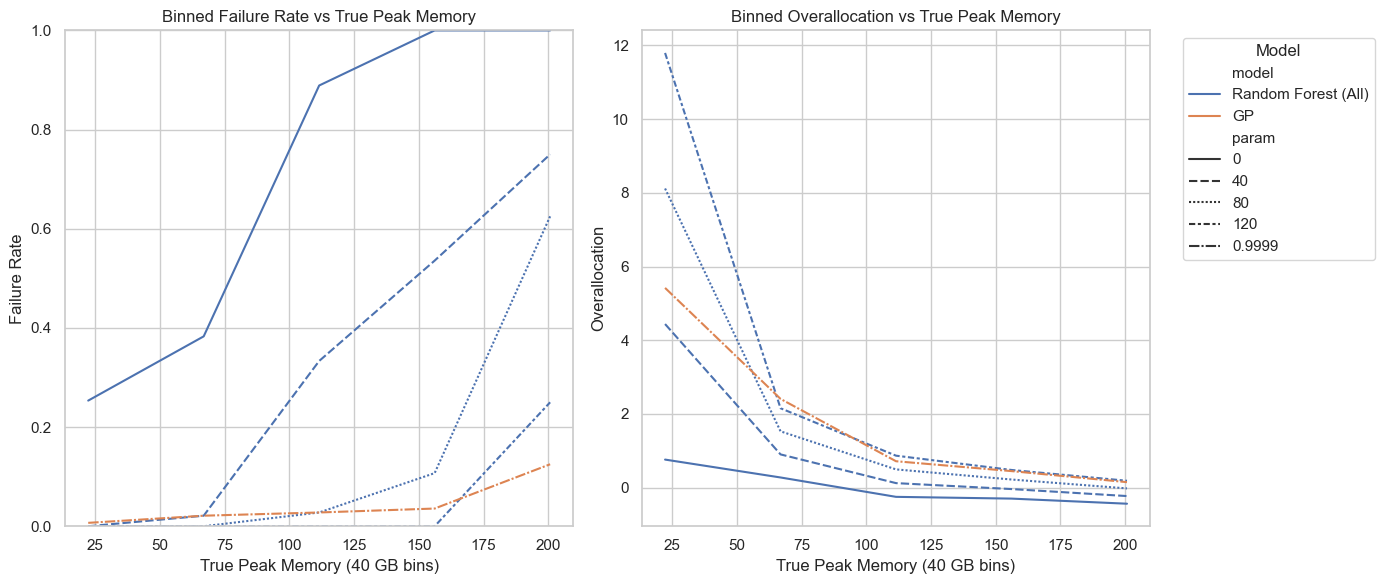

In [93]:

# 2 sidebyside subplots of failure rate and overallocation vs bin_center
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharex=True)
sns.lineplot(data=mem_bined_stats_df, x='bin_center', y='failure_rate', hue='model',style="param", ax=ax1)
ax1.set_title('Binned Failure Rate vs True Peak Memory')
ax1.set_xlabel('True Peak Memory (40 GB bins)')
ax1.set_ylabel('Failure Rate')
ax1.set_ylim(0, 1)
# hide legend
ax1.legend_.remove()
# ax1.legend(None)

sns.lineplot(data=mem_bined_stats_df, x='bin_center', y='overallocation', hue='model',style="param", ax=ax2)
ax2.set_title('Binned Overallocation vs True Peak Memory')
ax2.set_xlabel('True Peak Memory (40 GB bins)')
ax2.set_ylabel('Overallocation')
ax2.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
# plt.savefig("binned_failure_overallocation.png", dpi=150)

# 🎯 3. Explain the “Why” — Interpretation, Not Just Observation

Once you’ve revealed the insight, explain *why* it matters.

* Connect the finding to **human or business implications**.
- Models low MAE, MSE, R2 do not necessary perform well for this problem as the metric doesnot dicern between underestimation, and overestimation. But in real life this means failure of jobs, and posibly resource duplication for retry jobs.
- Bulk waste/safety metric does not dicern between different job sizes, and biases the metric toward the distribution of evaluation dataset

* Interpret the *drivers* and *consequences* of the pattern.
- HPC administator are more concened about large mem jobs, as they have limited machines with high memories. 
- Users are more concerned about jobs failing due to underestimation, as they have to wait longer.

* Translate stats into **meaning**.
This means that model selection should be based on metrics that reflect real-world usage:
- Evaluation metrics on different job sizes should reflect the actual distribution of jobs requested (users send mostly some type of metagenomes i.e. gut)
- Evaluation metric should take into account the **Total cost for one job**:
$$
C(y; a_0) = 
\underbrace{\sum_{r=0}^{R-1} C_{\text{fail}}(y, a_r)}_{\text{cost of retries}} 
+ 
\underbrace{C_{\text{over}}(y, a_R)}_{\text{waste on the successful attempt}}
$$




### 🔧 4. Support with Evidence — Show, Don’t Tell

* Use one clear, **simple visual** (not a dashboard) to let the insight stand out.
* Annotate your chart or highlight key points — make it impossible to miss.
* Use color or motion to draw the eye where it matters.

---



In [77]:
# Example usage

# dummy_policy = lambda R, a0: a0*2**(R)
dummy_policy = lambda R, a0: a0*(R+1)
y_true = 120.0  # True peak memory in GB
true_wall_time = 50.0  # True wall time in hours

# list of simulated initial allocation
allocations = [25.0, 110.0, 160.0]


In [161]:
# import JobCost from evaluation metrics in a way the if code changed after initial import ir reimports

from importlib import reload
import evaluation_metrics
reload(evaluation_metrics)
from evaluation_metrics import JobCost


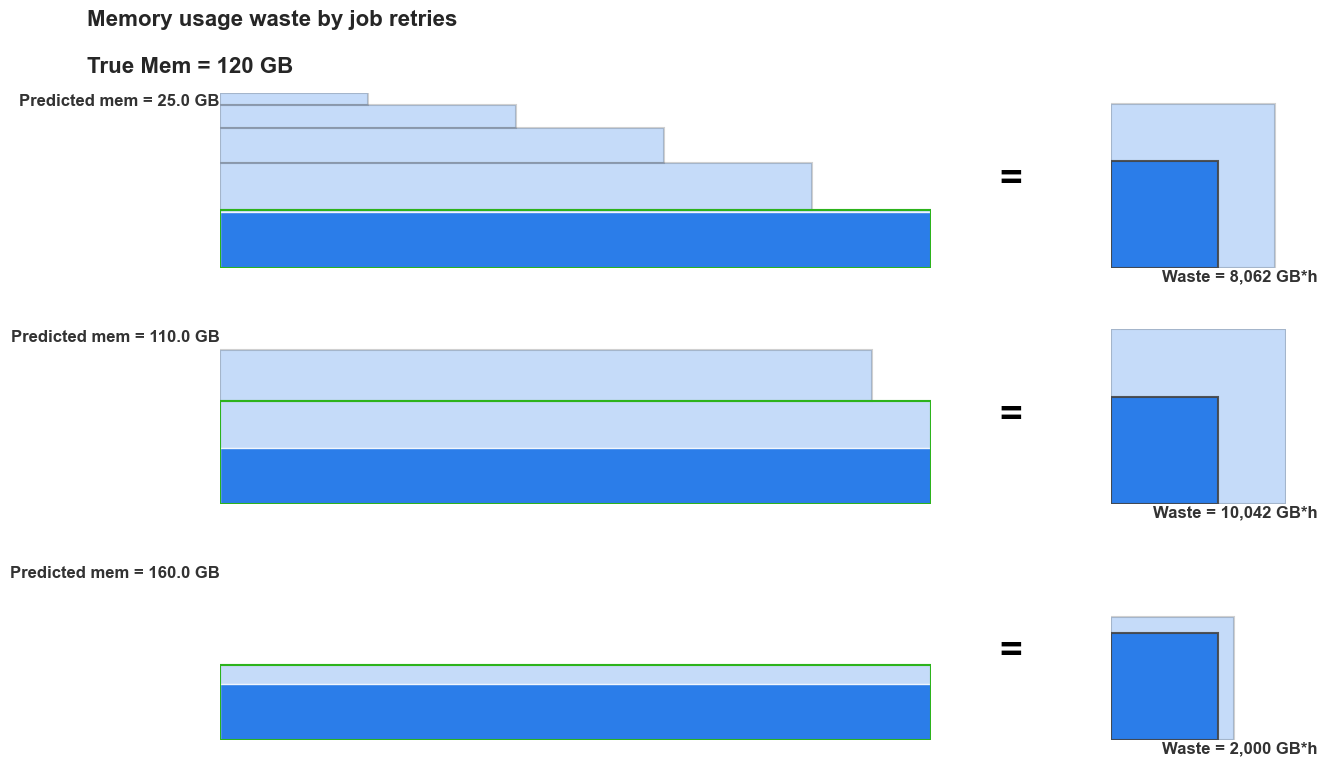

In [78]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np

def kill_axes(ax):
    ax.set_xticks([]); ax.set_yticks([])
    for side in ("left","right","top","bottom"):
        ax.spines[side].set_visible(False)

# ---------- gather results + global scales ----------
runs = []
max_job_width = 0.0
max_total_height = 0.0
max_outer_side = 0.0
inner_side = np.sqrt(y_true * true_wall_time)

for a0 in allocations:
    result = JobCost.job_cost(y_true, true_wall_time, dummy_policy, a0)
    runs.append((a0, result))
    max_job_width = max(max_job_width,
                        max([w for w,_ in result["failed_alloc_time"]] + [true_wall_time]))
    total_h = sum(h for _,h in result["failed_alloc_time"]) + result["a_R"]
    max_total_height = max(max_total_height, total_h)
    max_outer_side = max(max_outer_side, np.sqrt(result["total_mem_rate"]))

# ---------- layout ----------
n = len(runs)
fig = plt.figure(figsize=(14, 2.8 * n))
gs = fig.add_gridspec(nrows=n, ncols=3, width_ratios=[4.0, 0.35, 1.2], wspace=0.15, hspace=0.35)

for i, (a0, result) in enumerate(runs):
    axL = fig.add_subplot(gs[i, 0])  # jobs
    axE = fig.add_subplot(gs[i, 1])  # "="
    axR = fig.add_subplot(gs[i, 2])  # squares

    # ----- left: stack jobs top -> bottom; green on bottom -----
    total_h = sum(h for _,h in result["failed_alloc_time"]) + result["a_R"]
    y_top = total_h
    # failed jobs: first one ends up at the top
    for w, h in result["failed_alloc_time"]:
        y_top -= h
        axL.add_patch(Rectangle((0, y_top), w, h,
                                facecolor="#1A73E8", alpha=0.25, edgecolor="#444444",
                                linewidth=1.5, antialiased=True))
    
    # final job in red
    
    # final green job at y=0 (bottom)

    axL.add_patch(Rectangle((0, 0), true_wall_time, result["a_R"],
                        facecolor="#1A73E8", alpha=0.25, edgecolor="#2DB31C",
                            linewidth=1.5, antialiased=True))
    
    axL.add_patch(Rectangle((0, 0), true_wall_time, y_true,
                        facecolor="#1A73E8", alpha=0.9, 
                        linewidth=None, antialiased=True))

    axL.add_patch(Rectangle((0, 0), true_wall_time, result["a_R"],
                        facecolor="none", edgecolor="#2DB31C",
                            linewidth=1.5, antialiased=True))
    
    axL.set_xlim(0, max_job_width)
    axL.set_ylim(0, max_total_height)
    kill_axes(axL)  # <- removes spines so no line cuts through bars
    axL.text(0, max_total_height, f"Predicted mem = {a0:.1f} GB",
             ha="right", va="top", fontsize=12, fontweight="bold", color="#333")

    # ----- middle: equal sign (aligned across rows) -----
    kill_axes(axE)
    axE.text(0.5, 0.5, "=", ha="center", va="center",
             fontsize=28, fontweight="bold", color="black")

    # ----- right: blue squares (true squares) -----
    outer_side = np.sqrt(result["total_mem_rate"])
    axR.add_patch(Rectangle((0, 0), outer_side, outer_side,
                            facecolor="#1A73E8", alpha=0.25,
                            edgecolor="#444444", linewidth=1.5))
    axR.add_patch(Rectangle((0, 0), inner_side, inner_side,
                            facecolor="#1A73E8", alpha=0.90,
                            edgecolor="#444444", linewidth=1.5))
    axR.set_xlim(0, max_outer_side); axR.set_ylim(0, max_outer_side)
    
    axR.text(150, 0, f"Waste = {result['total_waste_rate']:,.0f} GB*h",
             ha="right", va="top", fontsize=12, fontweight="bold", color="#333")
    axR.set_aspect('equal', adjustable='box')
    kill_axes(axR)

fig.suptitle(f"Memory usage waste by job retries\n\nTrue Mem = {y_true:.0f} GB", fontsize=16, fontweight="bold",
             x=0.03, ha="left")
plt.tight_layout(rect=(0, 0, 1, 0.98))
plt.show()

### 🚀 5. End with Action — “What Now?”

Great insights inspire movement. Don’t stop at the reveal.

* End with what decision or action this insight should drive.
- concrete action is to use the propose evaluation method metrics to analyse and select best model for HPC resource estimation.
* Suggest a clear next step or hypothesis to test.
- I show on 3 different models the proposed evaluation method, and how it can be used to select best model.

> “By shifting our retention strategy toward onboarding engagement, we could reduce churn by up to 15%.”

---

## Our current allocation method


In [ ]:
biome_heuristic_table = pd.read_csv("./data/biome_assembler_heurs.tsv",sep="\t")
"""
memory_gb	process	assembler_name	biome_name	biome_lineage
80	ASSEM	flye	root	root
80	ASSEM	megahit	root	root
"""

def our_allocation_method(
        biome_lineage: str,
        process: str = "ASSEM",
        assembler_name: str = "metaspades",
) -> float:
        """
        finds the rows in biome_heuristic_table that match the process and assembler_name params,
        fot biome_lineage finds the most specific match (longest string match)
        returns the memory_gb value for that row
        if no match found, returns 80.0 (default)
        """
        biome_lineage = biome_lineage.lower().replace("-","_").replace(":",".").replace(" ","_")
        new_df = biome_heuristic_table[
                (biome_heuristic_table["process"] == process) &
                (biome_heuristic_table["assembler_name"] == assembler_name)
        ].copy()
        if new_df.empty:
                return 80.0
        # find most specific match for biome_lineage
        new_df["lineage_length"] = new_df["biome_lineage"].apply(len)

        new_df = new_df[new_df["biome_lineage"].apply(lambda x: biome_lineage.startswith(x))]
        if new_df.empty:
                return 80.0
        new_df = new_df.sort_values(by="lineage_length", ascending=False)
        return float(new_df.iloc[0]["memory_gb"])



In [75]:
## find the lineage of each sample in traing dataset
link_df = pd.read_csv("../../Kmer-Memory-Predict/input/updated_mgnify_assemblies_stats_v3.15.3_metaspades_subset.csv")
err_to_erz = dict(zip(link_df["srr_id"], link_df["primary_accession"]))
erz_to_biome = dict(zip(mgnify_dataset["primary_accession"], mgnify_dataset["lineage"]))
training_df_biomes = [erz_to_biome.get(err_to_erz.get(srr,""),"root") for srr in df.index]
heuristics_memory_allocation = [our_allocation_method(biome_lineage=bl) for bl in training_df_biomes]
quant_results[("Heuristic","default")] = np.array(heuristics_memory_allocation)

## Now show how each model predicts at each bin, but also shoing the memory usage waste based on above shown

## memory distribution

In [170]:
from importlib import reload
import evaluate_memory_allocation_methods
reload(evaluate_memory_allocation_methods)
from evaluate_memory_allocation_methods import HPCMemoryEvaluator, WeightingConfig

In [ ]:
# # from evaluate_memory_allocation_methods import (
# #     HPCMemoryEvaluator, WeightingConfig, synth_data,
# #     default_total_waste, default_total_wall_time,
# # )
# from evaluation_metrics import JobCost

# get true wall time
erz_to_wall_time = dict(zip(mgnify_dataset["primary_accession"], mgnify_dataset["wall_clock_seconds"]))
training_df_wall_time = (np.array([erz_to_wall_time.get(err_to_erz.get(srr,"")) for srr in df.index]) /60)/60 # in hours


# 1) Provide data
real_logs_peak_memory = mgnify_dataset["peak_mem_in_gbs"].to_numpy()               
sample_true = y.to_numpy()            
base_wall_time = training_df_wall_time
retry_policy = lambda R, a0: (R+1)*a0 # this is our current policy

predictors: Dict[str, np.ndarray] = {f"{x[0]} {x[1]}":quant_results[x] for x in [
    ('Heuristic', 'default'),
    ('File size (Linear)', 'default'),
    ('Random Forest (All)', 'default'),
    ('GP', 0.9)
    ]}  
predictors["Random Forest (All) + 120GB"] = predictors["Random Forest (All) default"] + 120.0
predictors["Dummy 80 GB"] = np.full_like(sample_true, 80.0)


# """TESTTT"""
# predictors = {}
# predictors['Dummy 20 GB'] = np.full_like(sample_true, 25.0)
# predictors['Dummy 110 GB'] = np.full_like(sample_true, 110.0)
# predictors['Dummy 160 GB'] = np.full_like(sample_true, 160.0)
# # simulate true_memor with mean ~ 120GB and stddev ~ 80GB, and true_time with mean ~ 50 hours and stddev ~ 20 hours
# # np.random.seed(42)
# sample_true = np.random.normal(loc=120.0, scale=20.0, size=sample_true.shape[0])
# base_wall_time = np.random.normal(loc=50.0, scale=20.0, size=sample_true.shape[0])
# real_logs_peak_memory = np.random.normal(loc=120.0, scale=20.0, size=sample_true.shape[0]*4)
# """TESTTT"""

# floor all prediction to at least 1GB. Random forest was giving 0
for k in predictors:
    predictors[k] = np.maximum(1.0, predictors[k])

# 2) Build evaluator
ev = HPCMemoryEvaluator(
    sample_peak_true=sample_true,
    pop_peak_true=real_logs_peak_memory,
    predictors=predictors,
    total_waste_fn=lambda mem_true,time_true,mem_pred: JobCost.batch_job_total_waste_rate(mem_true,time_true,retry_policy,mem_pred),      
    total_wall_time_fn=lambda mem_true,time_true,mem_pred: JobCost.batch_job_total_time(mem_true,time_true,retry_policy,mem_pred),       
    base_wall_time=base_wall_time,                               # or None if you don't have it
    weighting_cfg=WeightingConfig(nbins=60, log_scale=True),
)


# 3) Run
ev.compute_importance_weights()
summary_df, draws = ev.evaluate(n_jobs=1000, n_iter=4000, seed=123)

# 5) Persist or visualize
# ev.save_summary_csv("hpc_memory_eval_summary.csv")
print(summary_df.to_markdown(index=False))


| predictor                        |   waste_per_1000_mean |   waste_per_1000_lo |   waste_per_1000_hi |   wall_per_1000_mean |   wall_per_1000_lo |   wall_per_1000_hi |   failure_rate_mean |   failure_rate_lo |   failure_rate_hi |
|:---------------------------------|----------------------:|--------------------:|--------------------:|---------------------:|-------------------:|-------------------:|--------------------:|------------------:|------------------:|
| Heuristic default                |           3.27232e+06 |         2.40202e+06 |         4.46338e+06 |              50020.7 |            37389.7 |            67498   |          0.0367923  |             0.026 |          0.048    |
| File size (Linear) default       |           3.50772e+06 |         2.40938e+06 |         4.81952e+06 |              63550.9 |            46449.8 |            85888.1 |          0.116714   |             0.097 |          0.137    |
| Random Forest (All) default      |           3.51229e+06 |         2.3

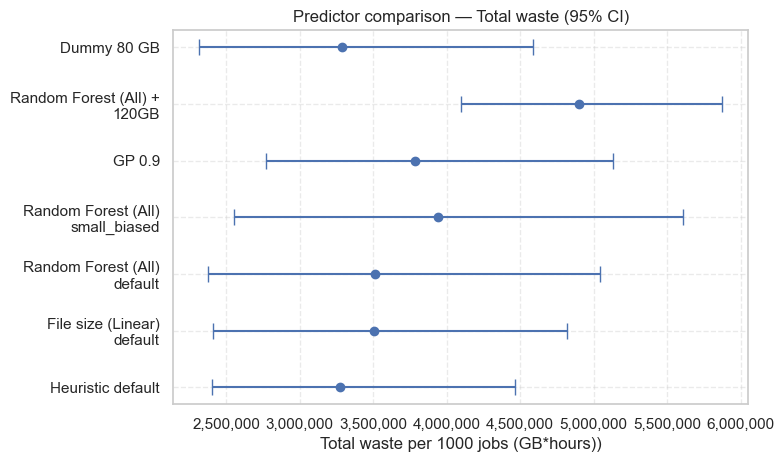

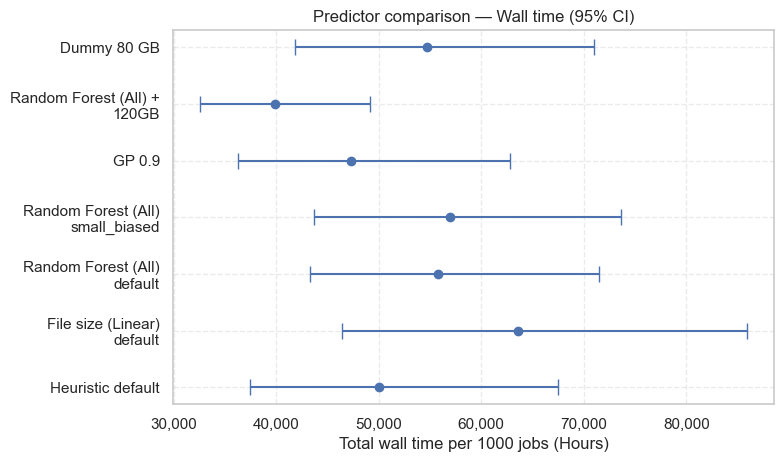

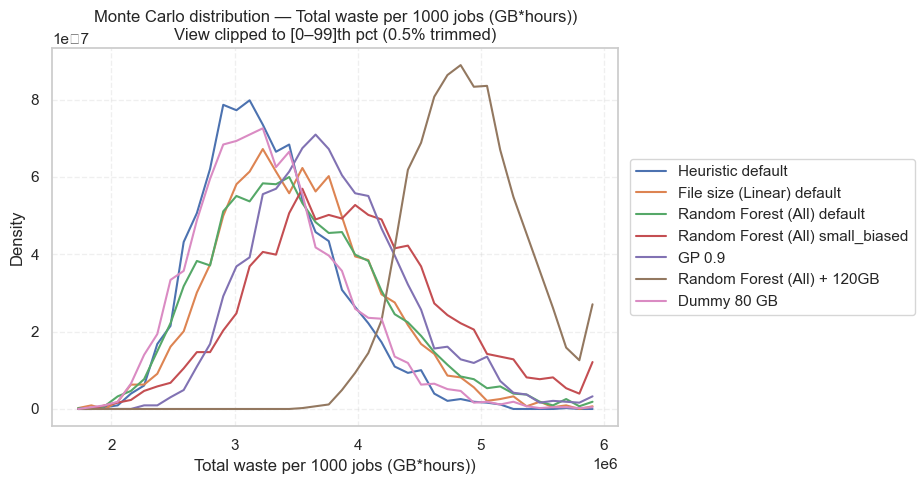

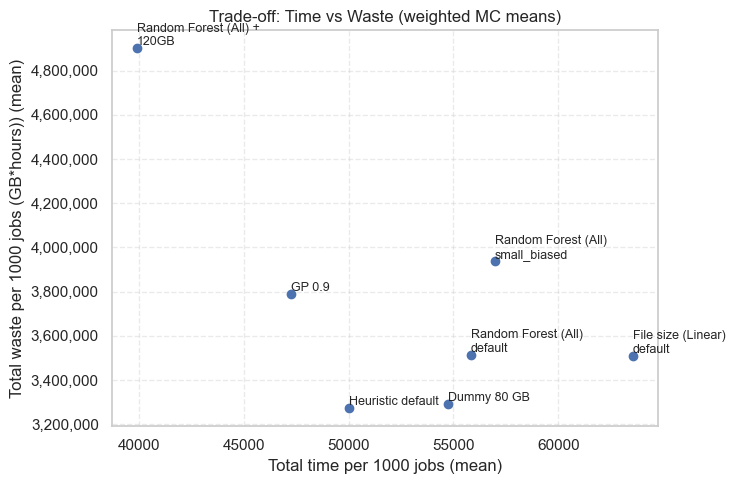

In [178]:

# Optional plots (require matplotlib)
ev.plot_errorbars(metric="waste")
ev.plot_errorbars(metric="wall")
# ev.plot_weighted_density(metric="waste", bins=50)
ev.plot_mc_distribution(metric="waste", bins=40)
ev.plot_tradeoff()


- The final idea is to use our method to select wich model is best
- Our method uses a calculated distribution of peak_mem_in_gbs and wall_time (from real mgnify data), called real_world_distribution
- Then based on real_world_distribution, we can weight each job in the evaluation dataset, to reflect how often this type of job is requested in real life
- 